In [1]:
import sys
import os
import numpy as np
from collections import OrderedDict
sys.path.append(os.pardir)
from common.layers import *
from common.gradient import numerical_gradient

# 5.7.1 신경망 학습의 전체 그림
"""
(4.5와 동일)
전제
신경망에는 적응 가능한 가중치와 편향이 있고, 이 가중치와 편향을 훈련 데이터에 적응하도록 조정하는 과정을 '학습'이라 한다.
신경망 학습은 다음과 같이 4단계로 수행한다.

1단계 - 미니배치
훈련 데이터 중 일부를 무작위로 가져온다. 이렇게 선별한 데이터를 미니배치라 하며,
그 미니배치의 손실함수 값을 줄이는 것이 목표이다.

2단계 - 기울기 산출
미니배치의 손실 함수 값을 줄이기 위해 각 가중치 매개변수의 기울기를 구한다.
기울기는 손실 함수의 값을 가장 작게 하는 방향을 제시한다.

3단계 - 매개변수 갱신
가중치 매개변수를 기울기 방향으로 아주 조금 갱신한다.

4단계 - 반복
1~3단계를 반복한다.

수치 미분과 오차역전파법은 2단계에서 사용
수치 미분은 구현은 쉽지만 계산이 오래걸림
오차역전파법을 통해 기울기를 효율적이고 빠르게 구할 수 있음
"""

# 5.7.2 오차역전파법을 이용한 신경망 구현하기
"""
TwoLayerNet 클래스로 구현
 * 클래스의 인스턴스 변수
params : 신경망의 매개변수를 보관하는 딕셔너리 변수.
        params['W1']은 1번째 층의 가중치, params['b1']은 1번째 층의 편향.
        params['W2']은 2번째 층의 가중치, params['b2']은 2번째 층의 편향.
layers : 신경망의 계층을 보관하는 순서가 있는 딕셔너리 변수
        layers['Affine1'], layers['Relu1'], layers['Affine2']와 같이
        각 계층을 순서대로 유지
lastLayer : 신경망의 마지막 계층(여기서는 SoftmaxWithLoss)

 * 클래스의 메서드
__init__(...) : 초기화 수행
predict(x) : 예측(추론)을 수행한다. x는 이미지 데이터
loss(x, t) : 손실함수의 값을 구한다. x는 이미지 데이터, t는 정답 레이블
accuracy(x, t) : 정확도를 구한다.
numerical_gradient(x, t) : 가중치 매개변수의 기울기를 수치 미분으로 구함(앞 장과 같음)
gradient(x, t) : 가중치 매개변수의 기울기를 오차역전파법으로 구함
"""


class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size,
        weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
            np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * \
            np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = \
            Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = \
            Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads

from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))
    
    


# 데이터 읽기
(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼 파라메터
iters_num = 10000  # 반복횟수
train_size = x_train.shape[0]
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # print(i)
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 오차역전파법으로 기울기 계산
    grad = network.gradient(x_batch, t_batch)

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # 1에폭 당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

"""
train acc, test acc | 0.0992833333333, 0.1032
train acc, test acc | 0.898, 0.9026
train acc, test acc | 0.92135, 0.9216
train acc, test acc | 0.936016666667, 0.9337
train acc, test acc | 0.945316666667, 0.9431
train acc, test acc | 0.94675, 0.9427
train acc, test acc | 0.954766666667, 0.9521
train acc, test acc | 0.9602, 0.9551
train acc, test acc | 0.9634, 0.9581
train acc, test acc | 0.9656, 0.9597
train acc, test acc | 0.9683, 0.9615
train acc, test acc | 0.970516666667, 0.9629
train acc, test acc | 0.97305, 0.9649
train acc, test acc | 0.9731, 0.9661
train acc, test acc | 0.975916666667, 0.9659
train acc, test acc | 0.976383333333, 0.9666
train acc, test acc | 0.977916666667, 0.969
[Finished in 45.5s]
"""

# 5.8 정리
"""
계산 과정을 시각적으로 보여주는 방법인 계산 그래프에 대해 학습했다.
계산 그래프를 통해 신경망의 동작과 오차역전파법을 설명하고, 계층이라는 단위로 구현했다.

"""

W1:2.735989814121131e-13
b1:7.380542374089625e-13
W2:9.570435819707124e-13
b2:1.207922664669958e-10
train acc, test acc | 0.11851666666666667, 0.1129
train acc, test acc | 0.9030666666666667, 0.9084
train acc, test acc | 0.9245333333333333, 0.9261
train acc, test acc | 0.9347833333333333, 0.9324
train acc, test acc | 0.9462, 0.9413
train acc, test acc | 0.9520833333333333, 0.9492
train acc, test acc | 0.95675, 0.9541
train acc, test acc | 0.9613166666666667, 0.9592
train acc, test acc | 0.9637333333333333, 0.9607
train acc, test acc | 0.9682333333333333, 0.9629
train acc, test acc | 0.9693166666666667, 0.9636
train acc, test acc | 0.9706166666666667, 0.9639
train acc, test acc | 0.9739666666666666, 0.9664
train acc, test acc | 0.9737666666666667, 0.9651
train acc, test acc | 0.9756333333333334, 0.9662
train acc, test acc | 0.9777666666666667, 0.9666
train acc, test acc | 0.97855, 0.9676


'\n계산 과정을 시각적으로 보여주는 방법인 계산 그래프에 대해 학습했다.\n계산 그래프를 통해 신경망의 동작과 오차역전파법을 설명하고, 계층이라는 단위로 구현했다.\n\n'

In [2]:
# 확률적 경사 하강법(Stochastic Gradient Descent)
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr # learning rate(학습률)
    
    def update(self, params, grads): 
        for key in params.keys(): # 가중치 매개변수와 기울기를 저장 eg: params['W1'] or grads['W1']
            params[key] -= self.lr * grads[key] # 학습률 * 기울기를 빼면서 점차 매개변수를 갱신(학습한다)

In [3]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
optimizer = SGD()

for i in range(10000):
    '''
    x_batch, t_batch = get_mini_batch()
    grads = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params, grads)
    '''

In [4]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None: # v는 물체의 속도
            self.v = {}
            for key, val in params.items(): 
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]
        

In [5]:
momentum = Momentum()
momentum.update(grad_numerical, grad_backprop)

In [6]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [7]:
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-1))

x = np.random.rand(1000, 100) # 1000개의 data
node_num = 100 # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.rand(node_num, node_num) / np.sqrt(node_num) # 가중치 랜덤
    a = np.dot(x, w) # 가중치, 입력값 행렬곱
    z = sigmoid(a) # 출력값을 산출, 활성화 함수는 sigmoid 함수를 사용
    activations[i] = z

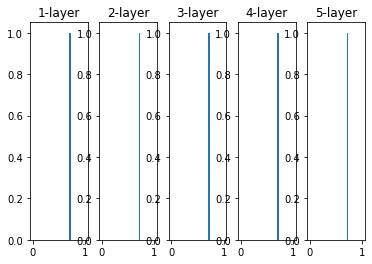

In [11]:
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0, 1))
plt.show()

In [10]:
node_num = 100
w = np.random.rand(node_num, node_num) / np.sqrt(node_num)
plt.show()

# 배치 정규화
배치 정규화 알고리즘은 2015년에 제안된 알고리즘으로 여러 장점이 있다.
- 학습을 빨리 진행할 수 있다(학습 속도 개선)
- 초깃값에 크게 의존하지 않는다(골치 아픈 초깃값 선택 장애 불필요)
- 오버피팅을 억제한다(드롭아웃 등의 필요성 감소)
## 배치 정규화의 기본 아이디어
- 각 층에서의 활성화 값이 적당히 분포되도록 조정하는 것이다. 
- 학습 시 미니배치를 단위로 정규화한다. 구체적으로는 데이터 분포의 평균이 0, 분산이 1이 되도록 정규화한다.
- 수식은 다음과 같다
    - $$\mu_B \leftarrow \frac{1}{m}\sum_{i=1}^{m} x_i$$
    - $$\alpha^2_B \leftarrow \frac{1}{m}\sum_{i=1}^m(x_i-\mu_B)^2$$
    - $$\hat{x}_i \leftarrow \frac{x_i-\mu_B}{\sqrt{\alpha^2_B+\epsilon}} $$
    

In [12]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
x_train = x_train[:300]
t_train = t_train[:300]
